Last notebook to run, and can customize to for specifc portoflio analysis

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import os 

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
    
print(f'Current Working Directory: {os.getcwd()}')

from utils.config import chosen_portfolio
from utils.finance_utils import plot_cum_ret

chosen_portfolio

Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py
Updated on 06/12/2025 3:11 2025-07-12

---------------------------------
finance_utils.py successfully loaded, updated on 07/12/2025 2:57
---------------------------------




{'Risky Asset Weight': 1.1610880015494847,
 'Risk-Free Asset Weight': 'None: Portfolio remains the same, this portfolio std was below Benchmark.',
 'Stocks': ['LRN', 'MGY', 'KGC', 'ABT', 'ATGE', 'OMAB', 'FINV', 'IDCC', 'SPY'],
 'Stock Weights': [0.25485541723966326,
  0.07546662363813973,
  0.17716086292717315,
  0.2451036768022216,
  0.057666392031968085,
  0.16509719898412803,
  0.004720749744566888,
  0.18101708018162393],
 'Expected Portfolio Return': 0.6251713769332887,
 'Expected Portfolio Standard Deviation': 0.20428190462991602,
 'Note': 'This is a Margin Portfolio'}

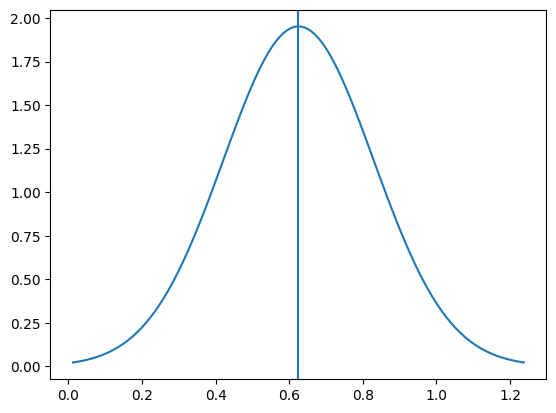

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = chosen_portfolio['Expected Portfolio Return']
sigma = chosen_portfolio['Expected Portfolio Standard Deviation']
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(x=mu)
plt.show()

In [3]:
# Functions

def merge_stock_df(stocks: list, stock_weights: list, existing_df: pd.DataFrame, paper_money: float) -> pd.DataFrame:
    """
    Merge existing valuation DataFrame with a simulated portfolio.
    
    Parameters:
    stocks (list): List of stock tickers in the portfolio.
    stock_weights (list): Corresponding weight allocations for each stock.
    existing_df (pd.DataFrame): DataFrame containing stock valuation data.
    paper_money (float): Total portfolio value, default is $30,000.
    
    Returns:
    pd.DataFrame: Merged DataFrame containing stock tickers, allocations, and valuation data.
    """
    real_allocation = dict(zip(np.array(stocks), (np.array(stock_weights)*paper_money)))
    real_allocation_df = pd.DataFrame(list(real_allocation.items()), columns=['Tickers', 'Weights_dollar'])
    
    merged_df = pd.merge(left=real_allocation_df, right=existing_df, on='Tickers', how='left')
    
    return merged_df.sort_values(by='Weights_dollar', ascending=False)




def get_stock_info(stocks: list, info_to_get: list) -> pd.DataFrame:
    if len(stocks) > 50:
        return 'Please set up logging, before getting info'
    
    end_list = []  # List of dictionaries

    for stock in stocks:
        stock_info = yf.Ticker(stock).info
        stock_data = {val: stock_info.get(val) for val in info_to_get}
        stock_data['Tickers'] = stock  # Add ticker symbol
        end_list.append(stock_data)  
        
    df = pd.DataFrame(end_list)
    
    if 'exDividendDate' or 'earningsTimestamp' in df.columns:
        df['exDividendDate'] = pd.to_datetime(df['exDividendDate'], unit='s')
        df['earningsTimestamp'] = pd.to_datetime(df['earningsTimestamp'], unit='s')

    # Convert list of dictionaries into DataFrame
    return df


def check_optionable(ticker: str) -> bool:
    try:
        return not yf.Ticker(ticker).option_chain().calls.empty
    except Exception:
        return False

In [4]:
CASH = 	33_000.00 # adjust cash here to see dollar avraging cost

valuation_df = pd.read_csv('data/clean/filtered_valuation_df.csv')
portfolio = merge_stock_df(chosen_portfolio['Stocks'], chosen_portfolio['Stock Weights'], valuation_df, paper_money=CASH)

vals_to_get = ['industry', 'beta', 'averageAnalystRating', 
               'country', 'dividendYield', 'exDividendDate', 
               'overallRisk', 'currentPrice', 'earningsTimestamp', 
               'currentRatio', 'debtToEquity'
] # KPI's to get from yf

In [5]:
stock_info_sharpe = get_stock_info(portfolio['Tickers'].to_list(), vals_to_get) # df of val to get, and respective values
complete_portfolio_info = pd.merge(left=portfolio, right=stock_info_sharpe, left_on='Tickers', right_on='Tickers')
complete_portfolio_info['Is_optionable'] = complete_portfolio_info['Tickers'].apply(check_optionable)

In [6]:
complete_portfolio_info['Num_of_shares'] = complete_portfolio_info['Weights_dollar']/complete_portfolio_info['currentPrice'] # simply seeing total num of shares for avaibale option strategies
complete_portfolio_info.sort_values(by='Weights_dollar', ascending=False) # Note: with dollar cost averaging, num of shares is only a approx. as price flucates

,Tickers,Weights_dollar,Sharpe_ratios,Sector,title,marketCap,trailingPE,forwardPE,profitMargins,trailingEps,...,country,dividendYield,exDividendDate,overallRisk,currentPrice,earningsTimestamp,currentRatio,debtToEquity,Is_optionable,Num_of_shares
0,LRN,8410.228769,1.483840,Consumer Defensive,"Stride, Inc.",5.853449e+09,21.113031,18.524794,0.13098,6.37,...,United States,NaN,NaT,6.0,134.49,2025-04-29 20:15:00,5.613,57.949,True,62.534231
1,ABT,8088.421334,1.292091,Healthcare,ABBOTT LABORATORIES,2.296937e+11,17.145456,25.585274,0.31886,7.70,...,United States,1.74,2025-07-15,7.0,132.02,2025-07-17 12:30:00,1.780,27.087,True,61.266636
2,IDCC,5973.563646,1.878982,Technology,"InterDigital, Inc.",5.842761e+09,17.821993,46.639750,0.48139,12.64,...,United States,1.07,2025-07-09,3.0,225.27,2025-05-01 12:30:00,1.763,51.907,True,26.517351
3,KGC,5846.308477,2.309481,Basic Materials,KINROSS GOLD CORP,1.911453e+10,15.867347,17.670454,0.21740,0.98,...,Canada,0.77,2025-05-29,2.0,15.55,2025-07-30 20:00:00,2.827,17.078,True,375.968391
4,OMAB,5448.207566,1.456871,Industrials,Central North Airport Group,5.457172e+09,19.814360,19.506895,0.34505,5.71,...,Mexico,4.30,2025-05-23,NaN,113.14,2025-07-28 20:00:00,1.772,95.480,True,48.154566
5,MGY,2490.398580,1.443851,Energy,Magnolia Oil & Gas Corp,4.584683e+09,11.792079,12.215385,0.28503,2.02,...,United States,2.67,2025-05-12,3.0,23.82,2025-07-30 20:00:00,1.334,20.683,True,104.550738
6,ATGE,1902.990937,1.497722,Consumer Defensive,Adtalem Global Education Inc.,4.239145e+09,19.964468,17.931610,0.13341,5.91,...,United States,NaN,2016-11-30,2.0,117.99,2025-08-07 20:00:00,0.833,54.479,True,16.128409
7,FINV,155.784742,1.867060,Financial Services,FinVolution Group,2.686189e+09,7.625900,7.210885,0.19415,1.39,...,China,2.92,2025-04-16,NaN,10.60,2025-05-20 22:00:08,6.342,0.374,True,14.696674


In [14]:
print(complete_portfolio_info.columns)
complete_portfolio_info[['Tickers', 'Weights_dollar', 'Sharpe_ratios', 'Sector', 'averageAnalystRating', 'profitMargins', 'overallRisk', 'beta', 'title', 'industry']]

Index(['Tickers', 'Weights_dollar', 'Sharpe_ratios', 'Sector', 'title',
       'marketCap', 'trailingPE', 'forwardPE', 'profitMargins', 'trailingEps',
       'quickRatio', 'earningsQuarterlyGrowth', 'industry', 'beta',
       'averageAnalystRating', 'country', 'dividendYield', 'exDividendDate',
       'overallRisk', 'currentPrice', 'earningsTimestamp', 'currentRatio',
       'debtToEquity', 'Is_optionable', 'Num_of_shares'],
      dtype='object')


,Tickers,Weights_dollar,Sharpe_ratios,Sector,averageAnalystRating,profitMargins,overallRisk,beta,title,industry
0,LRN,8410.228769,1.483840,Consumer Defensive,None,0.13098,6.0,0.356,"Stride, Inc.",Education & Training Services
1,ABT,8088.421334,1.292091,Healthcare,2.0 - Buy,0.31886,7.0,0.737,ABBOTT LABORATORIES,Medical Devices
2,IDCC,5973.563646,1.878982,Technology,None,0.48139,3.0,1.369,"InterDigital, Inc.",Software - Application
3,KGC,5846.308477,2.309481,Basic Materials,1.9 - Buy,0.21740,2.0,0.760,KINROSS GOLD CORP,Gold
4,OMAB,5448.207566,1.456871,Industrials,2.4 - Buy,0.34505,NaN,0.698,Central North Airport Group,Airports & Air Services
5,MGY,2490.398580,1.443851,Energy,2.5 - Buy,0.28503,3.0,1.286,Magnolia Oil & Gas Corp,Oil & Gas E&P
6,ATGE,1902.990937,1.497722,Consumer Defensive,None,0.13341,2.0,0.933,Adtalem Global Education Inc.,Education & Training Services
7,FINV,155.784742,1.867060,Financial Services,1.0 - Strong Buy,0.19415,NaN,0.410,FinVolution Group,Credit Services


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  9 of 9 completed


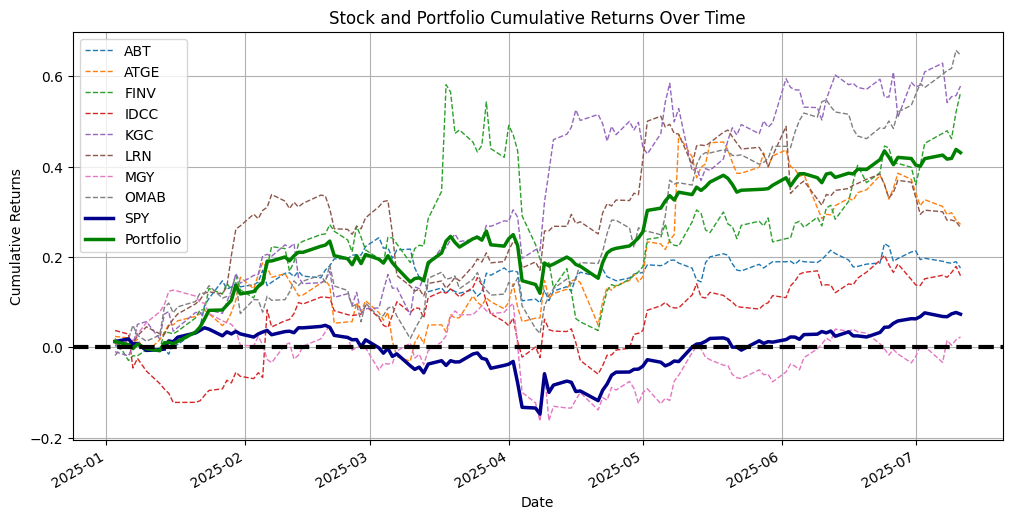

In [8]:
# plot stress test on portfolio, against a benchmark

stress_start = '2025-01-01'
stress_end = '2026-01-01'

plot_cum_ret(chosen_portfolio['Stocks'], chosen_portfolio['Stock Weights'], start_date=stress_start, end_date=stress_end)

([<matplotlib.patches.Wedge at 0x14bbedbd0>,
 [Text(-0.8899187390319623, 0.6465637152823859, 'Buy'),
  Text(0.8899186414035474, -0.6465638496563697, 'Strong Buy')],
 [Text(-0.4854102212901612, 0.3526711174267559, '80.0%'),
  Text(0.4854101680382985, -0.3526711907216562, '20.0%')])

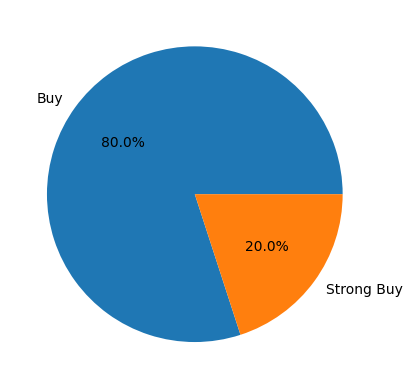

In [12]:
import matplotlib.pyplot as plt
# countries = complete_portfolio_info['country'].value_counts()
# plt.pie(countries.values, labels=countries.index, autopct='%1.1f%%')

# sectors = complete_portfolio_info['Sector'].value_counts()
# plt.pie(sectors.values, labels=sectors.index, autopct='%1.1f%%')

ratings = complete_portfolio_info['averageAnalystRating'].str.split(' - ', expand=True)[1].value_counts()
plt.pie(ratings.values, labels=ratings.index, autopct='%1.1f%%')

In [10]:
from datetime import datetime

earnings_time = datetime.fromtimestamp(1746534600)
print("Earnings Report:", earnings_time)

call_time = datetime.fromtimestamp(1746538200)
print("Earnings Call:", call_time)

Earnings Report: 2025-05-06 05:30:00
Earnings Call: 2025-05-06 06:30:00
